In [206]:
import os
import pandas as pd
import string
from datetime import datetime
from os import path
import json
import numpy as np
from pandas.tseries.offsets import MonthEnd

In [3]:
with open(path.expanduser("~") + "/sys_specific.json") as file: 
    params = json.load(file)
_HOME_ = params["home"] + "/PHD"

excel_path = _HOME_ + "/MSFD/Data/Modulo1/"

In [4]:
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params

# import data

In [5]:
raw_data = pd.read_csv(excel_path + "chemical_fis_raw.csv", dtype = str)

In [6]:
phyto_abundances = pd.read_csv(_HOME_ + "/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])

In [7]:
raw_data.rename(columns= {"NationalStationID" : "id", "Determinand_Nutrients" : "Nutrient"}, inplace=True)

# check id and date

In [8]:
raw_data["id"] = raw_data["id"].apply(lambda x: x.split(".")[0])
raw_data["id"] = raw_data["id"].apply(lambda x: str.strip(x))
raw_data["id"] = raw_data["id"].apply(lambda x: x.replace("M000200", "MS00200"))

In [9]:
raw_data["Year"] = raw_data["Year"].apply(lambda x: x.split(".")[0])
raw_data["Month"] = raw_data["Month"].apply(lambda x: x.split(".")[0])
raw_data["Day"] = raw_data["Day"].apply(lambda x: x.split(".")[0])

In [10]:
raw_data["Date"] = pd.to_datetime([f"{year}-{month}-{day}" for year, month, day in zip(raw_data["Year"], raw_data["Month"], raw_data["Day"])], format = "%Y-%m-%d")
raw_data.drop(columns = ["Year", "Month", "Day", "Time"], inplace=True)

In [11]:
raw_data["SampleDepth"] = raw_data["SampleDepth"].astype(float)

# check nutrients

In [12]:
#ox saturation
raw_data.loc[raw_data["Nutrient"].isin(['Temperature (water)', 'Temperature ', "Temperature"]), "Nutrient"] = "T"
raw_data.loc[raw_data["Nutrient"].isin(['Electrical Conductivity', ' Electrical Conductivity', 'Electrical conductivity']), "Nutrient"] = 'E_cond'
raw_data.loc[raw_data["Nutrient"].isin(['Dissolved Oxygen', 'Dissolved oxygen']), "Nutrient"] = 'DO'
raw_data.loc[raw_data["Nutrient"].isin([' ', 'Oxygen Saturation', 'Oxygen saturation']), "Nutrient"] = 'O_sat'

In [13]:
raw_data.loc[raw_data["Nutrient"].isin([' pH', 'pH ']), "Nutrient"] = 'pH'
raw_data.loc[raw_data["Nutrient"].isin(['Chlorophyll a']), "Nutrient"] = 'Chla'
raw_data.loc[raw_data["Nutrient"].isin(['Secchi depth']), "Nutrient"] = 'Secchi_depth'
raw_data.loc[raw_data["Nutrient"].isin(['Nitrate']), "Nutrient"] = 'NO3'
raw_data.loc[raw_data["Nutrient"].isin(['Nitrite']), "Nutrient"] = 'NO2'
raw_data.loc[raw_data["Nutrient"].isin(['Ammonium']), "Nutrient"] = 'NH4'
raw_data.loc[raw_data["Nutrient"].isin(['Total phosphorus', 'Total Phosphorus']), "Nutrient"] = 'TP'
raw_data.loc[raw_data["Nutrient"].isin(['Orthophosphates']), "Nutrient"] = 'PO4'
raw_data.loc[raw_data["Nutrient"].isin(['Total nitrogen', 'Total Nitrogen']), "Nutrient"] = 'TN'
raw_data.loc[raw_data["Nutrient"].isin(['Silicate']), "Nutrient"] = 'SiO4'

In [14]:
condition = (raw_data["id"] == "M1FV6")  & (raw_data["Date"] == datetime(2015,7,17)) & (raw_data["SampleDepth"].isin([42.0, 42.5])) & (raw_data["Nutrient"] == "E_cond")
raw_data.loc[condition, "Concentration"] = [46.6000, 46.5500]

In [15]:
raw_data["Concentration"] = raw_data["Concentration"].astype(str).apply(lambda x: x.replace(",", ".")).astype(float)

In [16]:
cond = (raw_data["Concentration"] >= 1000) & (raw_data["Nutrient"] == "T") & (raw_data["id"] == "M1T5C")
raw_data.loc[cond, "Concentration"] /= 10000

In [17]:
raw_data.dropna(subset = ["Concentration"], inplace=True)

In [90]:
already_done = True
if not already_done: 
    raw_data.loc[(~raw_data["Remarks"].isna()) & (raw_data["Nutrient"] != "Chla"), :].to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/remarks_nut.csv", index=0)

In [18]:
cond = (raw_data["id"] == "SMR_CCE_WA1") & (raw_data["Date"] == "2017-12-04") & (raw_data["Nutrient"] == "T") & (raw_data["SampleDepth"].isna())
raw_data.loc[cond, "SampleDepth"] = 40.5

In [19]:
secchi_depths = raw_data.loc[raw_data["Nutrient"] == "Secchi_depth", :].copy()
raw_data.drop(secchi_depths.index).dropna(subset = ["SampleDepth"], inplace=True)
raw_data.dropna(subset = ["SampleDepth"], inplace=True)

In [20]:
#add regions
raw_data = raw_data.merge(phyto_abundances.loc[:, ["id", "Region"]].drop_duplicates(), on = "id", how = "left")

In [22]:
#keep least deep measurements
#raw_data.sort_values(["Region", "id", "Date", "Nutrient", "SampleDepth"]).drop_duplicates(["Region", "id", "Date", "Nutrient"], keep = "first", inplace=True)

In [21]:
raw_data

,id,SampleDepth,Nutrient,Concentration,LOD_LOQ_Flag,Remarks,file_name,Date,Region
0,1004,0.5,Salinity,34.3091,NaN,NaN,Modulo_1E_20160608105053_ARPA_Emilia-Romagna_E...,2015-07-20,Emilia-Romagna
1,1004,0.5,T,27.6788,NaN,NaN,Modulo_1E_20160608105053_ARPA_Emilia-Romagna_E...,2015-07-20,Emilia-Romagna
2,1004,0.5,E_cond,54.9002,NaN,NaN,Modulo_1E_20160608105053_ARPA_Emilia-Romagna_E...,2015-07-20,Emilia-Romagna
3,1004,0.5,DO,5.8800,NaN,NaN,Modulo_1E_20160608105053_ARPA_Emilia-Romagna_E...,2015-07-20,Emilia-Romagna
4,1004,0.5,O_sat,90.7000,NaN,NaN,Modulo_1E_20160608105053_ARPA_Emilia-Romagna_E...,2015-07-20,Emilia-Romagna
...,...,...,...,...,...,...,...,...,...
1164183,1_ABR_VA15,88.0,E_cond,46.5813,NaN,NaN,Modulo_1_20200324122955_ARPA_Emilia-Romagna_Ab...,2017-10-03,Abruzzo
1164184,1_ABR_VA15,88.0,DO,6.5500,NaN,NaN,Modulo_1_20200324122955_ARPA_Emilia-Romagna_Ab...,2017-10-03,Abruzzo
1164185,1_ABR_VA15,88.0,O_sat,81.7000,NaN,NaN,Modulo_1_20200324122955_ARPA_Emilia-Romagna_Ab...,2017-10-03,Abruzzo
1164186,1_ABR_VA15,88.0,pH,8.2180,NaN,NaN,Modulo_1_20200324122955_ARPA_Emilia-Romagna_Ab...,2017-10-03,Abruzzo


## make wide table

In [18]:
#raw_data_wide = pd.pivot_table(raw_data, index = ["id", "Date", "SampleDepth"], columns = "Nutrient", values = "Concentration", aggfunc="mean")#.reset_index()

## ML data

In [22]:
ml_2016 = pd.read_excel(excel_path + "QC_2016_V28.02.2024.xlsx", dtype = str)
ml_2017 = pd.read_excel(excel_path + "QC_2017_V28.02.2024.xlsx", dtype = str)

In [23]:
ml_df = pd.concat([ml_2016, ml_2017], axis=0)

In [24]:
ml_ids = ml_df["LOCAL_CDI_ID"].unique()
ispra_ids = raw_data["id"].unique()
from_ml_to_ispra = {}
for ml_id in ml_ids:
    matching_ids = [ispra_id for ispra_id in ispra_ids if ispra_id in ml_id]
    from_ml_to_ispra[ml_id] = matching_ids

In [25]:
ml_df["LOCAL_CDI_ID"] = ml_df["LOCAL_CDI_ID"].apply(lambda x: from_ml_to_ispra[x][0])
ml_df["time_ISO8601"] = [date.replace(hour=0, minute=0, second=0, microsecond=0) for date in pd.to_datetime(ml_df["time_ISO8601"])]
ml_df["ADEPZZ01 [Meters]"] = ml_df["ADEPZZ01 [Meters]"].astype(float)

In [26]:
ml_df.rename(columns = {"time_ISO8601" : "Date", 
                        "ADEPZZ01 [Meters]" : "SampleDepth", 
                        'AMONFID2 [Micromoles per litre]': "NH4",
                        'QV:SEADATANET.2' : "QF_NH4", 
                        'CPHLFLP1 [Micrograms per litre]' : "Chla", 
                        'QV:SEADATANET.3' : "QF_Chla",
                        'DOXYSC01 [Micromoles per litre]' : "DO", 
                        'QV:SEADATANET.4' : "QF_DO",
                        'NTOTZZD2 [Micromoles per litre]' : "TN", 
                        'QV:SEADATANET.5' : "QF_TN",
                        'NTRAAA04 [Micromoles per litre]' : "NO3", 
                        'QV:SEADATANET.6' : "QF_NO3",
                        'NTRIAAD2 [Micromoles per litre]' : "NO2", 
                        'QV:SEADATANET.7' : "QF_NO2",
                        'PHOSAAD2 [Micromoles per litre]' : "PO4", 
                        'QV:SEADATANET.8' : "QF_PO4",
                        'PSALCC01 [Dimensionless]' : "Salinity", 
                        'QV:SEADATANET.9' : "QF_Salinity",
                        'SECCSDNX [Metres]' : "Secchi_depth",
                        'QV:SEADATANET.10' : "QF_Secchi_depth",
                        'SLCAAAD2 [Micromoles per litre]' : "SiO4",
                        'QV:SEADATANET.11' : "QF_SiO4",
                        'TEMPCC01 [Degrees Celsius]' : "T", 
                        'QV:SEADATANET.12' : "QF_T",
                        'TPHSZZXX [Micromoles per litre]' : "TP", 
                        'QV:SEADATANET.13' : "QF_TP",
                        "LOCAL_CDI_ID" : "id"
                        }, 
                        inplace=True)

In [27]:
ml_df = ml_df[['id', 'Bot. Depth [m]', 'Date', 'SampleDepth', 'NH4', 'QF_NH4', 'Chla', 'QF_Chla', 'DO', 'QF_DO', 'TN', 'QF_TN', 'NO3', 'QF_NO3', 'NO2', 'QF_NO2', 'PO4', 'QF_PO4', 'Salinity', 'QF_Salinity', 'Secchi_depth', 'QF_Secchi_depth', 'SiO4', 'QF_SiO4', 'T', 'QF_T', 'TP', 'QF_TP']]

In [28]:
nutrients = ["NH4", "Chla", "DO", "TN", "NO3", "NO2", "PO4", "Salinity", "Secchi_depth", "SiO4", "T", "TP"]
for nutrients in nutrients:
    ml_df[nutrients] = ml_df[nutrients].astype(float)

In [29]:
ml_df = ml_df.merge(phyto_abundances.loc[:, ["id", "Region"]].drop_duplicates(), on = "id", how = "left")

In [30]:
nutrients = ["NH4", "Chla", "DO", "TN", "NO3", "NO2", "PO4", "Salinity", "Secchi_depth", "SiO4", "T", "TP"]
QF_nutrients = ["QF_NH4", "QF_Chla", "QF_DO", "QF_TN", "QF_NO3", "QF_NO2", "QF_PO4", "QF_Salinity", "QF_Secchi_depth", "QF_SiO4", "QF_T", "QF_TP"]

In [31]:
ml_long = pd.DataFrame()
for nutrient, QF_nutrient in zip(nutrients, QF_nutrients):
    ml_long = pd.concat([ml_long, ml_df.loc[:, ["id", "Region", "Date", "SampleDepth", nutrient, QF_nutrient]].rename(columns = {nutrient : "Concentration", QF_nutrient : "QF"}).dropna(subset = ["Concentration"]).assign(Nutrient = nutrient)], axis=0)

In [33]:
# keep least deep measurements
#ml_long.sort_values(["Region", "id", "Date", "Nutrient", "SampleDepth"]).drop_duplicates(["Region", "id", "Date", "Nutrient"], keep = "first", inplace=True)

# merge two datasets

## analysis

In [66]:
max_depth = 10

In [ ]:
ml_long.query("SampleDepth < @max_depth").dropna(subset = ["Concentration"])

In [64]:
samples_not_in_ml = list(set(raw_data.loc[raw_data["Date"] >= datetime(2016,1,1), ].groupby(["id", "Date"]).count().index) - (set(ml_df.groupby(["id", "Date"]).count().index)))
samples_not_in_ml = raw_data.set_index(["id", "Date"]).loc[(samples_not_in_ml), ["Region", "Nutrient", "Concentration", "SampleDepth", "LOD_LOQ_Flag"]].query("SampleDepth < @max_depth").rename(columns = {"LOD_LOQ_Flag" : "QF"}).reset_index()

In [84]:
samples_2015 = raw_data.loc[raw_data["Date"] <= datetime(2016,1,1), ["id", "Date", "Region", "Nutrient", "Concentration", "SampleDepth", "LOD_LOQ_Flag"]].query("SampleDepth < @max_depth").rename(columns = {"LOD_LOQ_Flag" : "QF"})

In [85]:
nut_nor_in_ml = raw_data.loc[(raw_data["Date"] >= datetime(2016,1,1)) & (raw_data["Nutrient"].isin(["O_sat", "E_cond", "pH"])) &(raw_data["SampleDepth"] < max_depth), ["id", "Date", "Region", "Nutrient", "Concentration", "SampleDepth", "LOD_LOQ_Flag"]].rename(columns = {"LOD_LOQ_Flag" : "QF"})

In [90]:
df_chem_phys = pd.concat([ml_long, samples_not_in_ml, samples_2015, nut_nor_in_ml], axis=0).drop_duplicates() 

In [212]:
df_chem_phys.to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys.csv", index=False)

## matching phyto samples

In [180]:
phyto_samples = phyto_abundances.loc[:, ["Region", "id", "Date"]].drop_duplicates()
phyto_samples = phyto_samples.loc[phyto_samples["Date"] <= datetime(2018,1,1), :]
ispra_samples = df_chem_phys.loc[:, ["Region", "id", "Date"]].drop_duplicates()

In [182]:
cond = (ispra_samples["Region"] == "Emilia-Romagna") & ((ispra_samples["Date"] == "2015-10-05") | (ispra_samples["Date"] == "2015-10-09"))
ispra_samples.loc[cond, "Date"] = datetime(2015, 9, 30)
cond = (ispra_samples["Region"] == "Marche") & ((ispra_samples["Date"] == "2016-03-08") | (ispra_samples["Date"] == "2016-03-02"))
ispra_samples.loc[cond, "Date"] = datetime(2016, 2, 27)
cond = (ispra_samples["Region"] == "Marche") & (ispra_samples["Date"].isin(["2017-04-04", "2017-04-05"]))
ispra_samples.loc[cond, "Date"] = datetime(2017, 3, 30)
cond = (ispra_samples["Region"] == "Marche") & (ispra_samples["Date"] == "2017-05-02")
ispra_samples.loc[cond, "Date"] = datetime(2017, 4, 30)
cond = (ispra_samples["Region"] == "Veneto") & (ispra_samples["Date"] == "2016-05-05")
ispra_samples.loc[cond, "Date"] = datetime(2016, 4, 30)

In [183]:
def nearest(items, pivot, key = lambda x, pivot: abs(x - pivot)):
    return min(items, key=lambda x: abs(x - pivot))

In [184]:
matched_dates = pd.DataFrame()
regions = []
ids = []
pivot_dates = []
nearest_dates = []
for (group, dates) in phyto_samples.groupby(["Region", "id"]): 
    id = group[1]
    ispra_dates = ispra_samples.query("id == @id")["Date"].to_numpy()    
    for pivot_date in dates["Date"]:
        pivot_dates += [pivot_date]
        nearest_dates += [nearest(ispra_dates, pivot_date)]
        regions += [group[0]]
        ids += [id]
matched_dates["Region"] = regions
matched_dates["id"] = ids
matched_dates["phyto_dates"] = pivot_dates
matched_dates["nearest_dates"] = nearest_dates
        

In [185]:
matched_dates.query("phyto_dates != nearest_dates")

,Region,id,phyto_dates,nearest_dates
115,Basilicata,M1_SINNI_3,2016-07-18,2016-07-12
160,Calabria,M1T3A,2017-11-22,2017-08-09
166,Calabria,M1T3B,2017-11-22,2017-08-09
172,Calabria,M1T3C,2017-11-22,2017-08-09
176,Calabria,M1T4A,2017-10-11,2017-10-03
183,Calabria,M1T4B,2017-10-11,2017-10-03
190,Calabria,M1T4C,2017-10-11,2017-10-03
193,Calabria,M1T5A,2017-09-28,2017-07-07
200,Calabria,M1T5B,2017-09-28,2017-07-07
207,Calabria,M1T5C,2017-09-28,2017-07-07


In [205]:
matched_dates = matched_dates.loc[~((matched_dates["phyto_dates"] - matched_dates["nearest_dates"]).dt.days >= 30), :]

In [208]:
matched_dates["phyto_dates"] = matched_dates["nearest_dates"] + MonthEnd(0)

In [210]:
matched_dates.to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/matched_dates_phyto_chemphys.csv", index=False)

In [217]:
df_chem_phys = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys.csv")

In [220]:
df_chem_phys["Date"] = pd.to_datetime(df_chem_phys["Date"])

In [221]:
cond = (df_chem_phys["Region"] == "Emilia-Romagna") & ((df_chem_phys["Date"] == "2015-10-05") | (df_chem_phys["Date"] == "2015-10-09"))
df_chem_phys.loc[cond, "Date"] = datetime(2015, 9, 30)
cond = (df_chem_phys["Region"] == "Marche") & ((df_chem_phys["Date"] == "2016-03-08") | (df_chem_phys["Date"] == "2016-03-02"))
df_chem_phys.loc[cond, "Date"] = datetime(2016, 2, 27)
cond = (df_chem_phys["Region"] == "Marche") & (df_chem_phys["Date"].isin(["2017-04-04", "2017-04-05"]))
df_chem_phys.loc[cond, "Date"] = datetime(2017, 3, 30)
cond = (df_chem_phys["Region"] == "Marche") & (df_chem_phys["Date"] == "2017-05-02")
df_chem_phys.loc[cond, "Date"] = datetime(2017, 4, 30)
cond = (df_chem_phys["Region"] == "Veneto") & (df_chem_phys["Date"] == "2016-05-05")
df_chem_phys.loc[cond, "Date"] = datetime(2016, 4, 30)

In [228]:
df_chem_phys.reset_index(inplace=True)

In [230]:
df_chem_phys.to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data.csv", index=False)

## else

In [60]:
import matplotlib.pyplot as plt

In [58]:
def compare_histograms(
    dfs,  
    variables : list[str], 
    sup_title : str=None, 
    titles : list[str]=None,
    legend_labels : list[str]=None,
    x_labels : list[str]=None,
    y_labels : list[str]="Relative frequency",
    n_bins : int = 50,
    **kwargs
): 
    if "figsize" in kwargs: 
        figsize_dims = kwargs["figsize"]
    else: 
        figsize_dims = (8,8) if len(variables) == 1 else (8,13)
        
    if len(variables) == 1: 
        fig, axs = plt.subplots(1,1, figsize=figsize_dims)
    else : 
        n_rows = len(variables) // 2 
        fig, axs = plt.subplots(n_rows,2, figsize=figsize_dims)
        axs = axs.flat
    
    if sup_title: 
        plt.suptitle(sup_title)
        
    for ax, var, title, x_label, y_label in zip(fig.axes, variables, titles, x_labels, y_labels):
        right_edge = -np.inf
        left_edge = np.inf
        datas = [df[var].dropna().to_numpy() for df in dfs]
        for data in datas:
            right_edge = data.max() if right_edge < data.max() else right_edge
            left_edge = data.min() if left_edge > data.min() else left_edge
            
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        for data, label in zip(datas, legend_labels): 
            ax.hist(data, 
                    bins=np.linspace(left_edge,right_edge, n_bins, endpoint=True), 
                    alpha=0.5, 
                    weights=np.ones_like(data) / len(data),
                    label=label)
            ax.legend()
        
        fig.tight_layout()


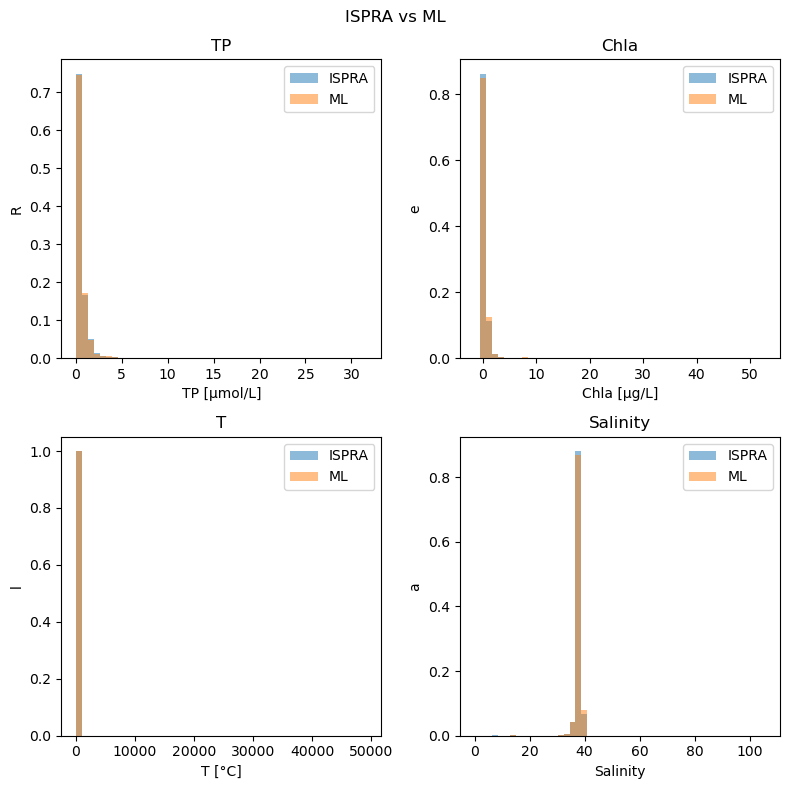

In [61]:
compare_histograms([raw_data_wide, ml_df], variables= ["TP", "Chla", "T", "Salinity"], titles = ["TP", "Chla", "T", "Salinity"], legend_labels = ["ISPRA", "ML"], x_labels = ["TP [µmol/L]", "Chla [µg/L]", "T [°C]", "Salinity"], sup_title = "ISPRA vs ML", figsize=(8,8))